# DPNNet-RT -- 22 October 2022

##### This notebook develops a ML model that can Classify and Predict the number of hidden planets and the corresponding planet mass for each of the planets from the protoplanetary disk images directly.

In [1]:
#####    Please note this version of the code is compatible with Google colab  ####
##################################### Mount the drive if running from Colab ##########################################
# from google.colab import drive
# drive.mount('/content/drive/')

### IDEA behind this notebook : 
#### Authors : Sayantan and Subhrat
#### Created : 3 Feb 2022
#### This notebook is adopted from the DPNNet-2.0 

- Update 1: 24 Feb 2022 to include multi-outputs
- Update 2: 22 October 2022 to include the all the date from the 700 FARGO3D calculations

This notebook is developed to train the Model with Radiative Transfer (RT) images:
We want to perform the following set of tasks

P.S. This is a modular notebook that does the following:

 1. Import all the customized Modules from Modules_DPNNet 
 2. For data processing we use data_processing_RT.py script 
 3. A functional module to call the different networks independently. (deep_models.py, other_cnn.py)
 4. On October 2022, we are updating this notebook. We can now access the complete data but shall choose randomly from the images
 5. Still only considering the axysymmetric images



In [38]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from sklearn.utils import shuffle
from tensorflow import keras as k
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Trasfer Learning Models

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5 
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import ResNet50,ResNet50V2
import re

## Modules for hyperparameter tuning keras-tuner
# import keras_tuner as kt

## Checking the availbale number of GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:",gpu.name,"Type:",gpu.device_type)
print("TensorFlow version used ",tf.__version__)

Num GPUs Available:  1
Name: /physical_device:GPU:0 Type: GPU
TensorFlow version used  2.10.0


#### Folder management

In [17]:
############ Please provide the path to the code directory if using Colab ################

# Path_gdrive= '/content/drive/MyDrive/ISU_Regresion/DPNNet-RT/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")

Creation of the directory data_folder failed/ not needed as it already exit
Creation of the directory figures failed/ not needed as it already exit
Creation of the directory saved_model failed/ not needed as it already exit
[INFO] Modules imported


### Creating a csv with simulations params and path to each RT images

In [18]:
## Taking a look at the paramter file 
parameter_df = dp.load_parameter_csv(path)
parameter_df

,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,a_grain_mic
0,0.000322,0.00204,0.001210,0.050,0.001,1.570000,0.0432,1.0,0.010,1.010,2.19,3.22,3000.0
1,0.002280,0.00154,0.000963,0.025,0.010,1.570000,0.0561,1.0,0.075,0.943,2.16,3.37,1000.0
2,0.002450,0.00262,0.002460,0.025,0.010,1.570000,0.0261,1.0,0.075,1.160,1.84,3.15,10000.0
3,0.000917,0.00195,0.001050,0.010,0.001,1.570000,0.0496,1.0,0.250,1.100,1.82,2.99,10000.0
4,0.001770,0.00187,0.002210,0.025,0.050,1.570000,0.0625,1.0,0.075,0.863,2.08,3.32,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.002110,0.00000,0.000000,0.025,0.005,0.000157,0.0454,1.0,0.010,1.100,1.94,3.29,100.0
696,0.002530,0.00000,0.000000,0.025,0.010,0.000157,0.0882,1.0,0.075,0.851,1.99,3.10,100.0
697,0.000577,0.00000,0.000000,0.025,0.001,0.000157,0.0732,1.0,0.250,1.130,2.00,3.35,100.0
698,0.001940,0.00000,0.000000,0.025,0.050,0.000157,0.0711,1.0,0.075,0.966,2.02,3.32,100.0


# Model Selections and Hyperparameters

- Select the resolution of the images. For res > Cutoff_resolution, generators are used as that allow the network to load images during training directly from the data folder. For lower resolution images, those are loaded directly to the RAM memory.
- Select number of sims and the nums of images from each sim for training
- Regression or Classification: For Classification one can tune the hyperparameter of the layer succeding the main network
- Select either network directly, so use transfer learning for the more advanced RESNET type networks
- Select the batch sizes, epochs and initial learning rate. Note for hyper parameter tuning the default epoch is set to 10. 




In [28]:
#### Desired Image resoltuion  and Batch Size #####
X_res = Y_res =128

## For random sampling from the images
num_sims = 700 
axisymmetric = True
num_ims_per_sim = 30  ## Choose the number of images from each FARGO3D sims

## Select the kind of Traning ## Both can be selected as well
REG =False#True  ## When choosing regression
CLA =True #False #False #True  ## When Choosing Clasiffication

hyperparam_tune = False ## Only used when classification is true 

Cutoff_resolution = 256

## Select the Network type

# NETWORK = "Vanilla" ## Cannot be uses at the moment
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
# NETWORK = "RESNET50"

                                ########## When using Trasnfer Learning ######################
NETWORK = "TL"
# transfer_model= ResNet50
transfer_model=EfficientNetB3

## Hyper-Parameter to define
batch_size = 50 ## 20 was for regression ## the best was for 200 last run
valid_batch_size = 100
epochs=400 ## best was 100
init_lr = 1e-5 # 1e-5 (works for regression)

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02,
                                           patience=50, verbose=1, mode='min',restore_best_weights=True)



#### Address to the data folder 
Genrating the .csv file with the image address to load them later

In [29]:
############# Address to the data folder ###################

# ## updating the image paths once the transfer is done
try:     
    list_RT_path = glob.glob(path+ 'image_directory_complete/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim
    # ## For google colab this needs to be updated
    list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images
    data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)
except ValueError:
    print("Looking for images in the folder above-- Please give the correct path to the images if images are not loaded")
    list_RT_path = glob.glob(path+ '../image_directory_complete/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim
    # ## For google colab this needs to be updated
    list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images
    data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)
    
    
# data_complete
## Removing the nan if any
data_complete.isna().sum()  # summing the number of na
data_complete= data_complete.dropna()
data_complete

# data_complete['Planet_Count'] = (data_complete.loc[:, ['Planet_Mass1', 'Planet_Mass2', 'Planet_Mass3']] != 0).sum(axis=1)
data_complete = shuffle(data_complete,random_state=42)
dc_list = []

for  i in range(1, num_sims+1):
  if axisymmetric == True:
    dc_list.append(data_complete.loc[data_complete['image_path'].str.contains('RT_A_' + str(i))][:num_ims_per_sim])
  else:
    dc_list.append(data_complete.loc[data_complete['image_path'].str.contains('RT_NA_' + str(i))][:num_ims_per_sim])

data_complete = pd.concat(dc_list)
data_complete = shuffle(data_complete,random_state=49)
data_complete

[INFO]: Importing path for all the RT images
Looking for images in the folder above-- Please give the correct path to the images if images are not loaded
[INFO]: Importing path for all the RT images
[INFO]: Contatination of the paths of all the RT images are now complete


,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,a_grain_mic,image_path
57335,164.000000,60.000000,240.000000,0.010,0.005,0.00523,0.0989,1.0,0.075,1.180,2.05,3.08,3000.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
43505,249.000000,903.333333,293.333333,0.010,0.010,0.00523,0.0732,1.0,0.075,0.954,2.13,2.98,100.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
61380,873.333333,0.000000,0.000000,0.025,0.005,0.00523,0.0325,1.0,0.250,0.874,1.85,3.01,100.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
13327,503.333333,333.333333,0.000000,0.010,0.001,1.57000,0.0304,1.0,0.010,1.150,1.91,3.11,3000.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
72584,646.666667,60.000000,127.000000,0.050,0.010,0.00157,0.0904,1.0,0.075,0.909,2.16,3.47,300.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65923,79.000000,763.333333,570.000000,0.050,0.001,0.00157,0.0882,1.0,0.075,1.020,2.03,3.25,1000.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
40206,420.000000,0.000000,0.000000,0.025,0.001,0.01570,0.0968,1.0,0.075,1.190,2.02,3.32,3000.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
39733,900.000000,0.000000,0.000000,0.025,0.005,0.01570,0.0496,1.0,0.250,1.150,2.08,3.37,1000.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...
79207,50.666667,0.000000,0.000000,0.010,0.005,0.00157,0.0411,1.0,0.010,1.190,1.97,3.22,100.0,/Users/auddy/Documents/Work/Projects/DPNNet-RT...


### Preparing data 

In [30]:
## partition the data csv file into training and testing splits using 85% of
## the data for training and the remaining 15% for testing
split = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split

## Save the train and the test data for future use as well.
test.to_csv(path+'data_folder/test_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')

## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path,multi_label=True)

[INFO] preparing the normalized data training/testing split...
Droping the irrelevant columns 
INFO: considering multiple planets as output
[INFO] Done...


### Loading the images or Creating the train, validation and test generators

In [33]:
import time
start = time.time()

if CLA == True:
        ### Preparing the dataset for the classification problem--- 
        ## For classification we included binary 1 or 0 depending on if the planet is present or not respectively
        train['Planet_Mass2'] = np.where(train['Planet_Mass2']!= 0, 1,0)
        train['Planet_Mass3'] = np.where(train['Planet_Mass3']!= 0, 1,0)
        # train = train.select_dtypes("string")
        test['Planet_Mass2'] = np.where(test['Planet_Mass2']!= 0, 1, 0)
        test['Planet_Mass3'] = np.where(test['Planet_Mass3']!= 0, 1, 0)
        
        Y_train=train[['Planet_Mass2','Planet_Mass3']] ## These are used as label for the non-generator training
        Y_test=test[['Planet_Mass2','Planet_Mass3']]

        y_col=['Planet_Mass2','Planet_Mass3']

elif REG == True:
        y_col=["Planet_Mass1",'Planet_Mass2','Planet_Mass3']

        
        ###### Generate the training and the test images######
if X_res >= Cutoff_resolution:
    
    def custom_augmentation(np_tensor):

        '''
        This function is used to crop the images when those are loaded using the 
        ImageDataGenerator Keras function. This custom augmentation function only
        works for three different res as given below. For other resolutions the 
        image needs to the cropped appropiately.

        '''

        # # # dimensions for cropping the image
        if X_res == 128:
          top,left,bottom,right = 20,25,110,90 
        if X_res == 256:          
          top,left,bottom,right = 40,50,220,180          
        if X_res == 512:
          top,left,bottom,right = 60,90,450,380          
                
        image = np.squeeze(np_tensor) 
        crop_image = image[top:bottom, left:right]
        crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
        crop_image = k.preprocessing.image.img_to_array(crop_image)
        return crop_image

#     datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,samplewise_center=True, samplewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
#     datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True,featurewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
    datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,rescale=1./255.,validation_split=0.15)

    #### TRAINING GENERATOR #####
    train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### VALIDATION GENERATOR #####
    validation_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### TESTING GENERATOR #####
    test_datagen= k.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_augmentation,rescale=1./255.)
    test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(X_res,Y_res))
    
    
    ## STEP SIZES later used for training using generators
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

 

else:
    print("Uploading directly to RAM as the image resoltuion is manageable")
    trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
    testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
print('There are {} Train, {} Validation and {} Test images'.format(int((1-Validation_split)*len(normed_train_data)),int(Validation_split*len(normed_train_data)),len(normed_test_data)))## check the numbers in each category
end = time.time()
print("Total time elapsed =", end - start)

# # Getting all memory using os.popen()
# total_memory, used_memory, free_memory = map(
#     int, os.popen('free -t -m').readlines()[-1].split()[1:])
 
# # Memory usage
# print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

Uploading directly to RAM as the image resoltuion is manageable
[INFO] Loading images from Train data..
Train Images are loaded
[INFO] Loading images from Test data..
Test Images are loaded
There are 13872 Train, 2448 Validation and 2880 Test images
Total time elapsed = 81.97813820838928


### Checking image with cropping for verification

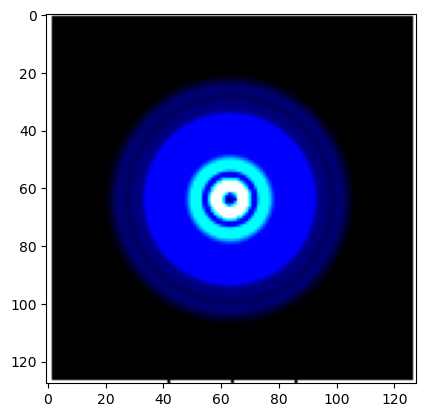

In [34]:
if X_res>= Cutoff_resolution:
    for _ in range(5):
        img, label = train_generator.next()
        print(img.shape)   #  (1,256,256,3)
        plt.imshow(img[0])
        plt.show()
else:
    plt.imshow(trainImagesX[5])
    plt.show()

# filenames =train_generator.filenames
# filenames[1]


## Preparing the Model Network

In [35]:
print('INFO: Currently training using the {} NETWORK with regression = {} and classification = {}'.format(NETWORK,REG,CLA))
if NETWORK == "Vanilla":
    CNN = dm.build_cnn(X_res, Y_res, 3, regress=True)
elif NETWORK == "ALEXNET":
    CNN = alexnet(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "VGG":
    CNN = cnn_vgg(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "RESNET50":
    # CNN = Resnet50(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
    CNN = ocn.Resnet50(X_res, Y_res, 3,classes=3,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "TL":      
    if hyperparam_tune == True and CLA ==True: 
        print("hyperparameters are only tuned for classification -- For regression hyperparams are standard and not tuned")
        hypermodel = ocn.TRANSFERLEARNINGHYPERMODEL(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None,transfer_model=transfer_model,
                                                   init_lr=init_lr,epochs=epochs)
        tuner_bo = kt.BayesianOptimization(
                hypermodel,
                objective=kt.Objective('loss', direction="min"),
                max_trials=5,
                seed=42,
                beta = 4.0,
                executions_per_trial=5,directory='Tuner',project_name= NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC'
            )
        tuner_bo.search(train_generator,
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=validation_generator,
                                validation_steps=STEP_SIZE_VALID,
                                epochs=epochs)
        CNN = tuner_bo.get_best_models(num_models=1)[0]
    else : 
        
         CNN = ocn.TRANSFERLEARNING(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None,transfer_model=transfer_model)
 
         optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/epochs)



INFO: Currently training using the TL NETWORK with regression = False and classification = True
INFO: Keras Model used is EfficientNetB3
Loading weights for efficientnetb3 since this notebook is not connected to internet
IF the notebook is connected to internet then the weights can be directly downloaded-- Choose accordingly
INFO:CNN is used for classification
Additional INFO: Using Sigmoid activation for classification
INFO: Classification Model is being trained


## Training

In [36]:
if REG == True and CLA ==False:
    
    CNN.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=['mean_absolute_error', 'mean_squared_error'])
    
    if X_res >= Cutoff_resolution:
        print("INFO: Switching to Generator as Resosultion is greater than {}: REGRESSION using GENERATORS".format(X_res))         
        CNN_history = CNN.fit(train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=validation_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=epochs,callbacks=[early_stop])
    else:

        CNN_history = CNN.fit(x=trainImagesX, y=train_labels,
                          validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])

if REG == False and CLA ==True:
    
    if hyperparam_tune == False: 
        CNN.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    if X_res >= Cutoff_resolution:          
        print("INFO: Switching to Generator as Resosultion is greater than {}: CLASSIFICATION using GENERATORS".format(X_res))  
        CNN_history = CNN.fit(train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=validation_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=epochs,callbacks=[early_stop])
    else: 
        
        CNN_history = CNN.fit(x=trainImagesX, y=Y_train,
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])

if REG == True and CLA ==True:
    
    # When used for classification and regression
    CNN.compile(loss=['mean_squared_error','binary_crossentropy'],optimizer=optimizer,metrics=['mean_squared_error', 'accuracy'])

    CNN_history = CNN.fit(x=X_train, y=[train_labels,Y_train],
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])
    
# total_memory, used_memory, free_memory = map(
# int, os.popen('free -t -m').readlines()[-1].split()[1:])

# # Memory usage
# print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

Epoch 1/400


2022-11-17 11:21:51.967121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5084

2022-11-17 11:24:18.473272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - 163s 526ms/step - loss: 0.6936 - accuracy: 0.5084 - val_loss: 0.6978 - val_accuracy: 0.1287
Epoch 2/400
278/278 [==============================] - 124s 443ms/step - loss: 0.5119 - accuracy: 0.5288 - val_loss: 0.7526 - val_accuracy: 0.7398
Epoch 3/400
278/278 [==============================] - 124s 445ms/step - loss: 0.4410 - accuracy: 0.5340 - val_loss: 0.5544 - val_accuracy: 0.5825
Epoch 4/400
278/278 [==============================] - 123s 440ms/step - loss: 0.3905 - accuracy: 0.5418 - val_loss: 0.3938 - val_accuracy: 0.5674
Epoch 5/400
278/278 [==============================] - 124s 444ms/step - loss: 0.3603 - accuracy: 0.5459 - val_loss: 0.3733 - val_accuracy: 0.5458
Epoch 6/400
278/278 [==============================] - 122s 439ms/step - loss: 0.3338 - accuracy: 0.5526 - val_loss: 0.3326 - val_accuracy: 0.6148
Epoch 7/400
278/278 [==============================] - 125s 448ms/step - loss: 0.3166 - accuracy: 0.5582 - val_loss: 0.2742 - val_

278/278 [==============================] - 115s 413ms/step - loss: 0.0587 - accuracy: 0.6125 - val_loss: 0.1806 - val_accuracy: 0.4841
Epoch 57/400
278/278 [==============================] - 115s 413ms/step - loss: 0.0579 - accuracy: 0.6144 - val_loss: 0.1398 - val_accuracy: 0.4620
Epoch 58/400
278/278 [==============================] - 116s 416ms/step - loss: 0.0582 - accuracy: 0.6044 - val_loss: 0.1644 - val_accuracy: 0.5743
Epoch 59/400
278/278 [==============================] - 116s 416ms/step - loss: 0.0619 - accuracy: 0.6068 - val_loss: 0.0921 - val_accuracy: 0.6315
Epoch 60/400
278/278 [==============================] - 120s 433ms/step - loss: 0.0560 - accuracy: 0.6107 - val_loss: 0.0825 - val_accuracy: 0.4759
Epoch 61/400
278/278 [==============================] - 122s 440ms/step - loss: 0.0566 - accuracy: 0.6102 - val_loss: 0.2743 - val_accuracy: 0.5511
Epoch 62/400
278/278 [==============================] - 122s 439ms/step - loss: 0.0528 - accuracy: 0.6071 - val_loss: 0.3043 

278/278 [==============================] - 116s 416ms/step - loss: 0.0324 - accuracy: 0.5811 - val_loss: 0.4119 - val_accuracy: 0.4375
Epoch 112/400
278/278 [==============================] - 116s 415ms/step - loss: 0.0310 - accuracy: 0.5775 - val_loss: 0.1112 - val_accuracy: 0.4514
Epoch 113/400
278/278 [==============================] - 116s 416ms/step - loss: 0.0318 - accuracy: 0.5844 - val_loss: 0.1090 - val_accuracy: 0.4649
Epoch 114/400
278/278 [==============================] - 118s 423ms/step - loss: 0.0305 - accuracy: 0.5753 - val_loss: 0.0544 - val_accuracy: 0.5960
Epoch 115/400
278/278 [==============================] - 123s 440ms/step - loss: 0.0310 - accuracy: 0.5798 - val_loss: 0.1036 - val_accuracy: 0.4653
Epoch 116/400
278/278 [==============================] - 122s 438ms/step - loss: 0.0298 - accuracy: 0.5688 - val_loss: 0.1231 - val_accuracy: 0.4767
Epoch 117/400
278/278 [==============================] - 122s 439ms/step - loss: 0.0309 - accuracy: 0.5715 - val_loss: 0

## Saving the network and the loss history for future use

In [39]:
hist_df = pd.DataFrame(CNN_history.history)  ## converting to dataframe for future usels
## Saving the history and the model
if NETWORK == "TL":
    if REG == True and CLA == True:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC'+'_history.csv')
    elif REG == True and CLA == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR'+'_history.csv')    
    elif CLA == True and REG == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC')        
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC'+'_history.csv')
    
else:    

    if REG == True and CLA == True:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelRC'+'_history.csv')
    elif REG == True and CLA == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelR'+'_history.csv')    
    elif CLA == True and REG == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelC'+'_history.csv')

INFO:tensorflow:Assets written to: /Users/auddy/Documents/Work/Projects/DPNNet-RT/DPNNET-RT-3Nov22/Regression_runs_512/saved_model/TL_EfficientNetB3_128_modelC/assets


INFO:tensorflow:Assets written to: /Users/auddy/Documents/Work/Projects/DPNNet-RT/DPNNET-RT-3Nov22/Regression_runs_512/saved_model/TL_EfficientNetB3_128_modelC/assets


TypeError: Unable to serialize [2.0896919 2.1128855 2.108185 ] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

# Loading the model

In [ ]:
if NETWORK == "TL":
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC')
        
    print("INFO:The Trained model {} at res {} is loaded ".format(NETWORK+'_'+str( transfer_model.__name__),str(X_res)))
else:
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')

### Model Predictions and Results for the regression and Classification

In [40]:
test_index = 41 # 550  #550 ##210
if X_res >= Cutoff_resolution:

    test_generator.reset()
    pred_CNN=CNN.predict_generator(test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)
else:
    
    pred_CNN = CNN.predict(testImagesX)  
pred_CNN[test_index]

2022-11-17 16:07:12.994438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 9s 64ms/step


array([0.991067 , 0.9896541], dtype=float32)

In [41]:
test_index = 111 # 550  #550 ##210#
# plt.imshow(testImagesX[test_iclass_mode])
if REG == True:
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))
elif CLA == True:
    print("The predicted prbability of the presence of planets are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],Y_test.iloc[test_index]))
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))
    

The predicted prbability of the presence of planets are [0.00394408 0.00258754] and 
The True values are 
Planet_Mass2    0
Planet_Mass3    0
Name: 39122, dtype: int64 
The predicted Values are [0.00394408 0.00258754] and 
The True values are 
Planet_Mass1    446.666667
Planet_Mass2      0.000000
Planet_Mass3      0.000000
Name: 39122, dtype: float64 


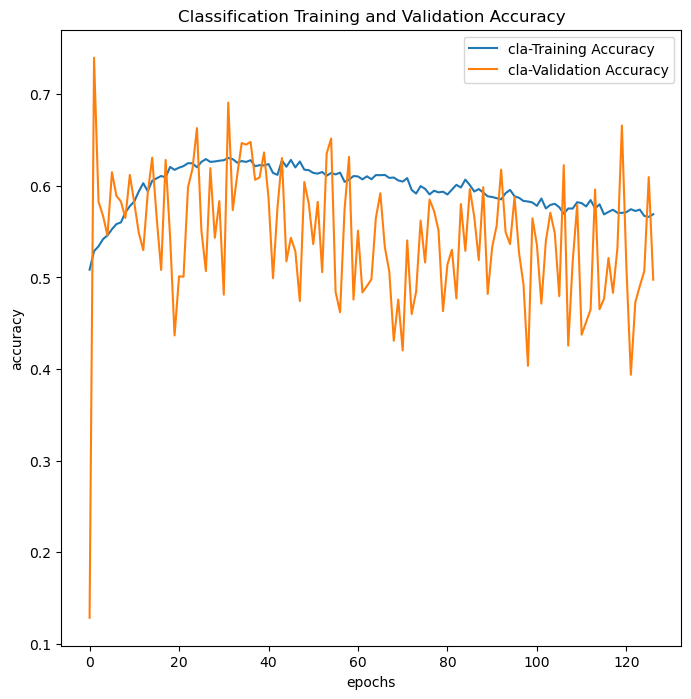

In [42]:
###fc_mean_squared_error fc_accuracy dense_3_mean_squared_error dense_3_accuracy
hist =pd.DataFrame(CNN_history.history)
hist['epoch'] = hist.index = hist.index
hist
if NETWORK == "TL":
    plot_name = NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)
else:
    plot_name = NETWORK+'_'+str(X_res)
if  CLA == True and REG== False:
    cla_acc = CNN_history.history['accuracy']
    val_cla_acc = CNN_history.history['val_accuracy']
    cla_loss =CNN_history.history['loss']
    val_cla_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='cla-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='cla-Validation Accuracy')
    
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title('Classification Training and Validation Accuracy')
    plt.savefig('figures/'+plot_name+'_c.png')
    plt.show()
    
if REG == True and CLA == False:
    ## For Regression
    reg_mse = CNN_history.history['mean_squared_error']
    val_reg_mse =CNN_history.history['val_mean_squared_error']
    reg_loss =CNN_history.history['loss']
    val_reg_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    # plt.ylim(0,50000)
    plt.plot(hist['epoch'], reg_mse, label='reg-Training MSE')
    plt.plot(hist['epoch'], val_reg_mse, label='reg-Validation MSE')
    plt.legend(loc='upper right')
    plt.title('Regression Training and Validation MSE')
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.show()
    plt.savefig('figures/'+plot_name+'_r.png')

if REG == True and CLA == True:
    ## For classification
    cla_acc = CNN_history.history['cla_accuracy']
    val_cla_acc = CNN_history.history['val_cla_accuracy']
    cla_loss =CNN_history.history['cla_loss']
    val_cla_loss = CNN_history.history['val_cla_loss']

    ## For Regression
    reg_mse = CNN_history.history['reg_mean_squared_error']
    val_reg_mse =CNN_history.history['val_reg_mean_squared_error']
    reg_loss =CNN_history.history['reg_loss']
    val_reg_loss = CNN_history.history['val_reg_loss']
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='cla-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='cla-Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("epochs")
    plt.ylabels("accuracy")
    plt.title('Classification Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(hist['epoch'], reg_mse, label='reg-Training MSE')
    plt.plot(hist['epoch'], val_reg_mse, label='reg-Validation MSE')
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.title('Regression Training and Validation MSE')
    plt.savefig('figures/'+plot_name+'_cr.png')